In [2]:
import pandas as pd
import numpy as np
import math
import sys 
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss F.softmax
import torch.optim as optim #optim.sgd
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy import special

from locale import format
from dataclasses import dataclass, MISSING
from sklearn import preprocessing #preprocessing.normalize


import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from icecream import ic  # for debugging. print variable name

from PC_param import default_parameters_network # To get the parameters
pars = default_parameters_network()

{'ae': 18.26, 'be': -5.38, 'hme': 78.67, 'ai': 21.97, 'bi': -4.81, 'hmi': 125.62, 'taue': 0.005, 'taui': 0.005, 'tauNMDA': 0.1, 'tauGABA': 0.005, 'tauAMPA': 0.002, 'gamma': 0.641, 'sigma': 0.0007, 'I0e': 0.2346, 'I0i': 0.17, 'sigmaIn': 3, 'sigmaEI': 3, 'sigmaInh': [0.2, 3], 'I_ext': 0.0, 'c_dash': 90, 'mu0': 30, 'Jext': 0.01, 'I1': 0.57, 'I2': 0.029999999999999992, 'Jee': 0.2, 'Jie': 0.2, 'Jei': 1.4, 'Jii': 6.7, 'Jin': 0.008, 'Jiq': 0.85, 'Jes': 3.5, 'Jsi': 0.12, 'Jem': 2.2, 'I_noise': array([[ 1.21787352e-03],
       [-7.55625551e-05],
       [-8.15148971e-04],
       [ 1.46897987e-04]]), 'T': 3, 'dt': 2e-05, 'r_init': 0.2, 'range_t': array([0.00000e+00, 2.00000e-05, 4.00000e-05, ..., 2.99994e+00,
       2.99996e+00, 2.99998e+00]), 'Lt': 150000, 'NumN': 20, 'f': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]), 'In0': 0, 'InMax': 50, 'Iq0': 0, 'IqMax': 10}


In [3]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class Model(nn.Module):
    def __init__(self, param, sim, dicJ):
        super(Model, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = sim.dt #torch.tensor(1e-4) #
        self.N = param.N #20
        self.taue = self.taui = torch.tensor(param.taue) #torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(param.ae)# 18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(param.be) #-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(param.hme)#78.67)
        self.ai = torch.tensor(param.ai)#21.97)
        self.bi = torch.tensor(param.bi)#-4.81)
        self.hmi = torch.tensor(param.hmi)#125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.dicJ = dicJ #kwargs
        """    self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))"""

        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True, dtype=torch.float64))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True, dtype=torch.float64))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True, dtype=torch.float64))

        #--- Initialize model variables here
    def initiate_state(self):
        self.prev_r_e = torch.zeros((self.N)) # torch.ones(self.N) shows more obvious results
        self.prev_r_i = torch.zeros((self.N))
        self.prev_s_ampa = torch.zeros((self.N))
        self.prev_s_gaba = torch.zeros((self.N))
        self.dr_e_dt = torch.zeros((self.N))
        self.dr_i_dt = torch.zeros((self.N))
        self.s_ampa = torch.tensor(0.)
        self.i_tot_e = torch.tensor(0.)
        self.i_tot_i = torch.tensor(0.)
		

    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.
        mulaI = a * I_tot
        addB = mulaI + b
        expo = torch.exp(-addB)
        return hm / (1 + expo)
        """mulaI =torch.mul(a, I_tot)
        addB= mulaI + b
        expo = torch.exp(- (addB))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))"""

    def forward(self, In):
        #--- Compute values of interest
        #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
        s_gaba_wie = self.prev_s_gaba @ self.wie
        s_ampa_wei = self.prev_s_ampa @ self.wei
        s_gaba_wii = self.prev_s_gaba @ self.wii
        JeeAmpa =  torch.mul(self.Jee, self.s_ampa)
        self.i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In))
        self.i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))
        #print("Jee after computation", self.Jee.grad_fn)
        """self.i_tot_e = (self.Jee * self.s_ampa) - (self.Jie * s_gaba_wie) + (self.Jin*  In)
        self.i_tot_i = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)"""

        phi_arr_e = self.phi(self.i_tot_e, self.ae, self.be, self.hme)
        phi_arr_i = self.phi(self.i_tot_i, self.ai, self.bi, self.hmi)

        self.dr_e_dt = (-self.prev_r_e + phi_arr_e) / self.taue
        self.dr_i_dt = (-self.prev_r_i + phi_arr_i) / self.taui

        r_e = self.prev_r_e+ self.dr_e_dt * self.dt
        r_i = self.prev_r_i + self.dr_i_dt * self.dt

        dS_amp_dt = (- self.prev_s_ampa / self.tauAMPA) + r_e
        s_ampa = self.prev_s_ampa+ dS_amp_dt * self.dt

        dS_gab_dt = (- self.prev_s_gaba / self.tauGABA) + r_i
        s_gaba = self.prev_s_gaba + dS_gab_dt * self.dt

        self.prev_r_e = r_e
        self.prev_r_i = r_i
        self.prev_s_ampa = s_ampa
        self.prev_s_gaba = s_gaba


        return self.prev_r_e, self.prev_r_i, self.dr_e_dt, self.dr_i_dt, self.prev_s_ampa, self.prev_s_gaba

## Functions

In [4]:
""" Plot HeatMap of firing rate function"""
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time ms", "Time ms"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()
    plt.show()


""" Filters gauss and Dog and LoG"""
def gaussian_filter(s, N):
    pop = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2

def dog_filter(sOut, N):
    sIn = sOut / 30
    pop = np.arange(1, N + 1)
    gaussIn = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(pop - pop[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog

def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""
 Normalization or transform to probability
"""

def make_it_proba(r_e):
    eps = torch.FloatTensor([sys.float_info.epsilon]) #torch.FloatTensor
    r_e_max = torch.max(r_e, eps.expand_as(r_e))
    threshold = 5# torch.FloatTensor([5]).expand_as(r_e[10,:])
    sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
 
    prob_r= 0.5 * (1 + torch.tanh(sum_r_e - threshold))*(r_e_max / sum_r_e) #r_e_max.sum())
    return prob_r #.reshape(r_e.shape[0], r_e.shape[1]) 

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)


''' Classic Normalization
use:
#preprocessing.normalize(re_numpy, axis= 0)[20,:].sum()

or use:
'''
def normalize(x):
    N = (x - x.min()) / (x.max() - x.min())
    return N


"""
Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""
def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation

def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  
    return torch.tensor(y)

def replace_argmax(r):
    # along some dimension (e.g., the last dimension).
    indices = torch.arange(r.shape[-1]).to(r.device)
    return torch.gather(indices, dim=-1, index=torch.argmax(r, dim=-1)).max()




""" Target design: Get the expected stimuli and then create a matrix of 1 where stimuli 0 elsewhere"""

def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1) #consider replacing argmax by replace_argmax
    Xmax = torch.max(Xargmax)
    return Xmax

def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable
    
    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)# replace where function by relu functio which is differentiable
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d



""" 
Optimization function
Make a function which save parameters of trained model and upload the new model with the updated parameters
"""

def model_with_saved_trained_param(old_model, optimizer, Model, param, sim, dicJ):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model(param, sim, dicJ)
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    #print(optimizer.param_groups[0]['params'])
    if old_model.Jee == new_mymodel.Jee:
        print("it works")
    print("old model Jee:",old_model.Jee,"new model Jee:", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel, optimizer


def load_weights(newmodel, modelpath): #string
        if '.pt' not in modelpath:
            modelpath += '.pt'      
        newmodel.load_state_dict(torch.load(modelpath))
        #new_mymodel = Model(param, sim, model.state_dict())
        return newmodel #, newmodel.state_dict() to access the param
    
def save_weights(oldmodel, modelpath, epoch=None):  #string
    if '.pt' not in modelpath:
            modelpath += '.pt'
    torch.save(oldmodel.state_dict(), modelpath)

    

"""
Model evaluation

function wich test the accuracy of a model with new parameters compared to expected results + loss values for every samples
"""
def test_model(model, test_dataloader, loss_f):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            # Calculate output
            Y_prediction, _, dredt, dridt = model(x_test[0])
            #Y_prediction_prob = make_it_proba(Y_prediction)

            # Calculate loss
            #loss = loss_f(Y_prediction_prob, y_test[0], dredt, dridt)
            loss = loss_f(Y_prediction, y_test[0], dredt, dridt)

            # Accuracy
            predictions = Y_prediction.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            #predictions = Y_prediction_prob.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            correct_predictions += (predictions == y_test[0]).sum().item() # calculates the number of correct predictions by comparing the rounded predictions with the true labels (y_test). It sums up the correct predictions over the batch.
            total_samples += y_test[0].numel() # adds the total number of samples/item in the current batch to the overall count.

            test_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(test_dataloader)

    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {average_loss:.4f}')
    return accuracy, average_loss



""" 
LOSS
"""

def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)




""" 
Run simulation over batchXtime
"""

def run_model_across_batch(Input, len_sim, model_instance):
    count = 0 
    P0 = torch.zeros_like(Input)  
    I0 = torch.zeros_like(Input)
    model_instance.initiate_state()

    for i in range(Input.shape[0]):
            count +=1
            P0[i,:], I0[i,:], dredt, dridt, ampa, gaba = model_instance.forward(Input[int(i),:])#.item()
            if count == len_sim: #train_IN.shape[1]: #if we end the simulation time and go to the next batch
                count = 0
                model_instance.initiate_state()

    return P0, I0





""" 
Plot Normalised predictions
"""
def plot_normalized_plot(P0, Ptrained, t):
    P0_np = np.array(P0.detach().numpy())
    PT_np = np.array(Ptrained.detach().numpy())

    P0_norm = preprocessing.normalize(P0_np, axis= 1) 
    PT_norm = preprocessing.normalize(PT_np, axis= 1) 

    plt.plot(np.arange(Ptrained.shape[1]), P0_norm[t,:], label = f"{t}ms, untrained")
    plt.plot(np.arange(Ptrained.shape[1]), PT_norm[t,:], label = f"{t}ms, trained")


## Class

### Simple Class

In [5]:

# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°
    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']
    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    #°°° Hard encode these parameters °°°
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    #N=20, sIn=.1, sOut=3., sEI=.2
    def __init__(self, sEI=.2, sIn=.1, sOut=3., N=20):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("Time step of the simulation (dt):", self.dt, "  Duration of simulation (T):", self.T,"s",
              "  Length of the time frame (Lt):", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=0, dur=0.05):#ISI=0.5, dur=0.2): #ISI=1, dur=0.2   # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        #f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f: #+2 to not lose dimension ! becareful! 
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt)+2, 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
    
        f_stim = fx_array # np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1
      
    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, N=20, f_stim=None, InMax=None, In0=None):
        paramf = np.arange(1, N+1)
        
        #mask the ground truth f_stim by a gaussian function
        w = np.exp(-(((paramf) - (self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N
        #ic((w).shape)
        #if I want to normalize w:
        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N +1, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        len_sim = len(range_sim)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, len_sim ,w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI,"s","  Size In", self.In.shape, "Size w:",
              self.w.shape, "  f_stim = total length simulation:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




#  °°° Data preparation °°°
        
""" 
1- create a big dataset for every stimuli input. In = X stimulus
2- Split In / X into train and test dataset: Split 70% into train dataset and 30% into test dataset
3- get expected Y / Target
4- Create the DataLoader merging Xtrain_tensor and Ytrain_tensor (Input and Target)
 """

class Batch:
    def __init__(self, param, simu,len_sim):
     # 1  \\\\\\\\\\\ BIG Bottom up sensory input
        self.IN= torch.zeros(len_sim, 20 ,20)
        self.get_sensory_input(param,simu)
        

    def get_sensory_input(self, param, simu):
        for i in range(0, param.N):
            index = i+1
            st = Stim(param,simu, dur=simu.T,f =[index], ISI=0) 
            In, _,_,_,_ =st.sensoryInput(param, simu, sigmaIn = 2.)
            self.IN[:,:, i] = torch.tensor(In)
            #sti = torch.tensor(In).float()

    # 2
    def train_test_dataset(self):
        #create a random list containing each of our stimuli types
        num_stimuli = self.IN.shape[2]
        rand_idx = np.arange(0, num_stimuli)
        rng = np.random.default_rng(1245)
        rng.shuffle(rand_idx)

        # split this random list into test and train index. and filter the IN with those indexes
        val_split_index = int(np.floor(0.7 * num_stimuli))
        test_idx, train_idx = rand_idx[val_split_index:], rand_idx[:val_split_index]
        
        train_IN = self.IN[:,:, train_idx].permute(2,0,1)
        test_IN = self.IN[:,:, test_idx].permute(2,0,1)

        return train_IN, test_IN

    # 3
    def get_Targets(self, Inputs):
        Targets = torch.zeros_like(Inputs)
        num_stimuli, _,_ = Inputs.shape
        for stim_idx in range(num_stimuli):
            Targets[stim_idx,:,:] = get_expected_Y_relu(Inputs[stim_idx,:,:])
        return Targets

    # 4
    def create_dataloader(self, Inputs, Targets):   
        dataset = TensorDataset(Inputs, Targets)
        return DataLoader(dataset, batch_size=1, shuffle = True) #one sample per batch

    # 5
    def preprocess_data(self):

        train_IN, test_IN = self.train_test_dataset()
        #get expected target for every stimuli type /batch
        train_Targets = self.get_Targets(train_IN) 
        test_Targets = self.get_Targets(test_IN) 

        train_dataloader = self.create_dataloader(train_IN, train_Targets)
        test_dataloader = self.create_dataloader(test_IN, test_Targets)
        return train_dataloader, train_Targets, train_IN, test_dataloader, test_Targets, test_IN
    
    #6
    def safety_plot(self, train_IN, train_Targets):  
        X_proba = make_it_proba(train_IN[4,:,:])
        Y = train_Targets[4,:,:]
        N = X_proba.shape[1]      
        t=48
        plt.plot(torch.arange(N), X_proba[t,:], label= f"Proba Input at t={t}") #not in proba
        plt.plot(torch.arange(N), Y.detach().numpy()[t,:], label = f"target at t={t}") #in proba
        plt.legend()



class Batch_for_NLLL:
    def __init__(self, IN):
        self.Input =  IN
        BatchxTime = self.Input.shape[0]*  self.Input.shape[1]
        self.Target_index = torch.zeros(BatchxTime)
        self.make_Target_index(self.Input)
        
        self.Input_reshaped = self.Input.reshape(self.Input.shape[0]*  self.Input.shape[1], self.Input.shape[2])
    
    def make_Target_index(self, Input):
        time_stim = 0
        for batch in range(0, Input.shape[0]):
            for time in range(0, Input.shape[1]):
                self.Target_index[time + time_stim] = get_stimuli_input(Input[batch,:,:]).item()
            time_stim += Input.shape[1]
        


### Classs Model

In [6]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class Model(nn.Module):
    def __init__(self, param, sim, dicJ):
        super(Model, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = sim.dt #torch.tensor(1e-4) #
        self.N = param.N #20
        self.taue = self.taui = torch.tensor(param.taue) #torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(param.ae)# 18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(param.be) #-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(param.hme)#78.67)
        self.ai = torch.tensor(param.ai)#21.97)
        self.bi = torch.tensor(param.bi)#-4.81)
        self.hmi = torch.tensor(param.hmi)#125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.dicJ = dicJ #kwargs
        """    self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))"""

        self.Jee = nn.Parameter(torch.tensor(self.dicJ['Jee'], requires_grad = True, dtype=torch.float64))
        self.Jei = nn.Parameter(torch.tensor(self.dicJ['Jei'], requires_grad = True, dtype=torch.float64))
        self.Jie = nn.Parameter(torch.tensor(self.dicJ['Jie'], requires_grad = True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(self.dicJ['Jii'], requires_grad = True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(self.dicJ['Jin'], requires_grad = True, dtype=torch.float64))

        #--- Initialize model variables here
    def initiate_state(self):
        self.prev_r_e = torch.zeros((self.N)) # torch.ones(self.N) shows more obvious results
        self.prev_r_i = torch.zeros((self.N))
        self.prev_s_ampa = torch.zeros((self.N))
        self.prev_s_gaba = torch.zeros((self.N))
        self.dr_e_dt = torch.zeros((self.N))
        self.dr_i_dt = torch.zeros((self.N))
        self.s_ampa = torch.tensor(0.)
        self.i_tot_e = torch.tensor(0.)
        self.i_tot_i = torch.tensor(0.)
		

    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
      
        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.
        mulaI = a * I_tot
        addB = mulaI + b
        expo = torch.exp(-addB)
        return hm / (1 + expo)
     

    def forward(self, In):
        #--- Compute values of interest
        #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
        s_gaba_wie = self.prev_s_gaba @ self.wie
        s_ampa_wei = self.prev_s_ampa @ self.wei
        s_gaba_wii = self.prev_s_gaba @ self.wii
        """
        JeeAmpa =  torch.mul(self.Jee, self.s_ampa)
        self.i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In))
        self.i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))
        #print("Jee after computation", self.Jee.grad_fn)
        """
        self.i_tot_e = (self.Jee * self.s_ampa) - (self.Jie * s_gaba_wie) + (self.Jin*  In)
        self.i_tot_i = (self.Jei * s_ampa_wei) - (self.Jii * s_gaba_wii)

        phi_arr_e = self.phi(self.i_tot_e, self.ae, self.be, self.hme)
        phi_arr_i = self.phi(self.i_tot_i, self.ai, self.bi, self.hmi)

        self.dr_e_dt = (-self.prev_r_e + phi_arr_e) / self.taue
        self.dr_i_dt = (-self.prev_r_i + phi_arr_i) / self.taui

        r_e = self.prev_r_e+ self.dr_e_dt * self.dt
        r_i = self.prev_r_i + self.dr_i_dt * self.dt

        dS_amp_dt = (- self.prev_s_ampa / self.tauAMPA) + r_e
        s_ampa = self.prev_s_ampa+ dS_amp_dt * self.dt

        dS_gab_dt = (- self.prev_s_gaba / self.tauGABA) + r_i
        s_gaba = self.prev_s_gaba + dS_gab_dt * self.dt

        self.prev_r_e = r_e
        self.prev_r_i = r_i
        self.prev_s_ampa = s_ampa
        self.prev_s_gaba = s_gaba


        return self.prev_r_e, self.prev_r_i, self.dr_e_dt, self.dr_i_dt, self.prev_s_ampa, self.prev_s_gaba

### Data preparation: Call class and Create Batch (Input stimuli + target)

In [7]:
# \\\\ Parameters
param = Parameter() # N=20

# \\\\ Simulation time: T in s  (2s before)
sim = Simulation(dt=1e-3,T=.0510) 
sim.printSim()

# \\\\ Bottom up sensory input
stimuli = Stim(param, sim, dur=sim.T, f=[8])
In, range_sim, len_sim, w, sigmaIn = stimuli.sensoryInput(param, sim, sigmaIn=2.) #2.
stimuli.printStim()

Time step of the simulation (dt): 0.001   Duration of simulation (T): 0.051 s   Length of the time frame (Lt): 51
frequence of stimulus f: [8]   ISI: 0 s   Size In (51, 20) Size w: (51, 20)   f_stim = total length simulation: (51, 1) sigmaIn: 2.0


torch.Size([714]) torch.Size([714, 20]) torch.Size([14, 51, 20])


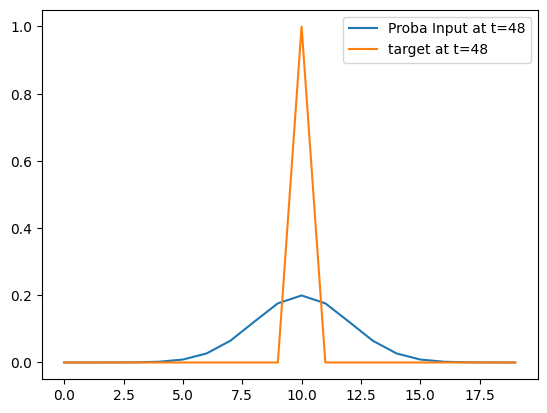

In [8]:
batch_instance = Batch(param=param, simu=sim, len_sim = sim.Lt)
train_dataloader, train_Targets, train_IN, test_dataloader, test_Targets, test_IN = batch_instance.preprocess_data()
batch_instance.safety_plot(train_IN,train_Targets)


batch_instance_NLLL = Batch_for_NLLL(train_IN)
Target_idx_NLLL = batch_instance_NLLL.Target_index
Input_NLLL =batch_instance_NLLL.Input_reshaped

print(Target_idx_NLLL.shape, Input_NLLL.shape, train_IN.shape)

0.072 ['Jee', 'Jei', 'Jie', 'Jii', 'Jin']


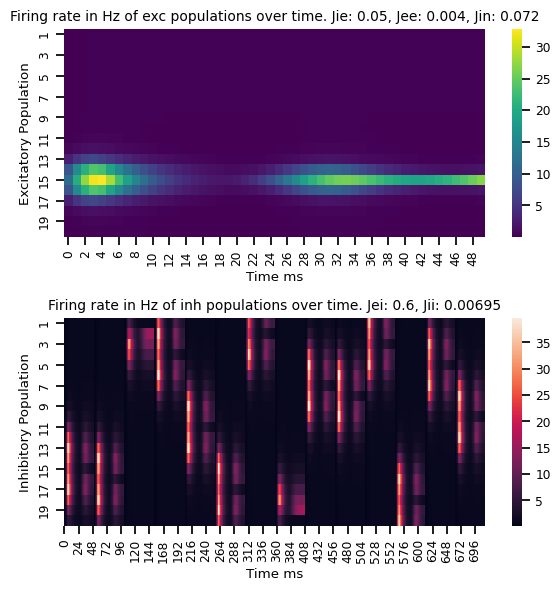

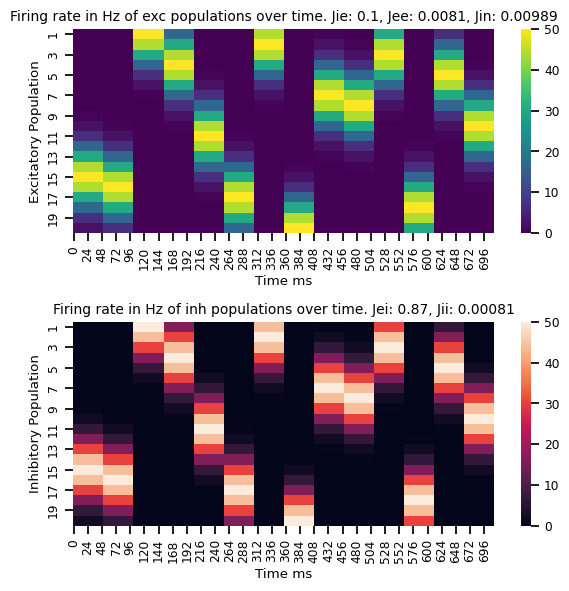

In [9]:
# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())
print(J1['Jee'], J_list)
model = Model(param=param, sim=sim, dicJ=J1)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

P0, I0 = run_model_across_batch(Input_NLLL, len_sim, model)

HeatMap(P0[:50,:].detach().numpy(), I0.detach().numpy(), J1)
HeatMap(Input_NLLL.detach().numpy(), Input_NLLL.detach().numpy())

### loosss

In [11]:
def custom_loss_(Prediction, Target, derivativeE):
  #1/ Proba term
  
  #logsoft = nn.LogSoftmax(dim=1)
  #criterion = torch.nn.CrossEntropyLoss()
  criterion = torch.nn.NLLLoss()
  P2 = make_it_proba(Prediction) #P2 = F.softmax(P, dim=1) #P2 = logsoft(P)#.t()
  loss_norm = criterion(P2, Target.long())

  
  #2/ derivative good 
  #stimu_pop_idx= Target_idx_NLLL# replace_argmax(Target) #stimu_pop_idx= torch.argmax(Target).item()
  #loss_derivative = - F.softplus(derivativeE[stimu_pop_idx] ).mean() + F.softplus(derivativeE[:stimu_pop_idx]).mean() + F.softplus(derivativeE[(stimu_pop_idx+1):]).mean()
  #sum instead of mean over time step
  loss_derivative = torch.zeros_like(Target)
  Target_idx_np = ((Target).numpy().astype(int))

  for i, sti_idx in enumerate(Target_idx_np):
    loss_derivative[i] = - F.softplus(derivativeE[:,sti_idx] ).sum() + F.softplus(derivativeE[:,:sti_idx]).sum() + F.softplus(derivativeE[:,(sti_idx+1):]).sum()

  loss_derivative_term = loss_derivative.mean()
  #3/ L2 regu term
  """l2_reg_coef=0.0001
  l2_reg = 0.0
  for param in mymodel.parameters():
      l2_reg += torch.sum(param**2)
  
  #L2_term = l2_reg * l2_reg_coef
  """
  #4/ High value of re term
  # I have to change that !! firing rate still decreased after loss
  """
    high_activity_penalty_coef=0.01

  if torch.max(re[:,stimu_pop]) > 50: #60
     high_activity_penalty = torch.sum(torch.sum(re[:, stimu_pop]**2)) #torch.clamp(r_e[:, 7], max=10.0
  else:
     high_activity_penalty = 0
  
  #activity_regularization = high_activity_penalty * high_activity_penalty_coef
    """
  coef_derivative = 0.000000001
  Cost = loss_norm + (coef_derivative * loss_derivative_term) #+  # + activity_regularization + L2_term 
  ic(loss_derivative_term * loss_derivative_term, loss_norm)
  return Cost

In [ ]:
def custom_loss_(Prediction, Target, derivativeE):
  #1/ Proba term
  criterion = torch.nn.NLLLoss()
  P2 = make_it_proba(Prediction) #
  loss_norm = criterion(P2, Target.long())

  
  #2/ derivative good 
  loss_derivative = torch.zeros_like(Target)
  Target_idx_np = ((Target).numpy().astype(int))

  for i, sti_idx in enumerate(Target_idx_np):
    loss_derivative[i] = - F.softplus(derivativeE[:,sti_idx] ).sum() + F.softplus(derivativeE[:,:sti_idx]).sum() + F.softplus(derivativeE[:,(sti_idx+1):]).sum()

  loss_derivative_term = loss_derivative.mean()

  coef_derivative = 0.000000001
  Cost = (coef_derivative * loss_derivative_term) + loss_norm 
  ic(loss_derivative_term, loss_norm)
  return Cost

In [12]:
train_Targets_reshaped = train_Targets.reshape(train_Targets.shape[0]*  train_Targets.shape[1], train_Targets.shape[2])

def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)

## Optimization

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3, min_delta=2)

In [14]:
train_Targets.shape

torch.Size([14, 51, 20])

In [15]:
model = Model(param=param, sim=sim, dicJ= J1)
model.initiate_state()
num_epoch = 15
losses = torch.zeros(num_epoch)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.NLLLoss()
logsoft = nn.LogSoftmax(dim=1)
learning_rate = 1E-2
optimizer = optim.Adam(model.parameters(),
                      lr=learning_rate) 
"""optim.SGD(model.parameters(),
                      lr=0.0001, weight_decay = 0.001)""" 

T = Target_idx_NLLL 
Input = Input_NLLL 


model.train()
for epoch in range(num_epoch):
    model.initiate_state()
    optimizer.zero_grad()  
    P = torch.zeros(Input.shape)   
    I = torch.zeros(Input.shape) 
    dPdt = torch.zeros_like(Input)  

    count = 0
    for i, b in enumerate(T):
        count +=1
        P[i,:], I[i,:], dPdt[i,:], dridt, ampa, gaba = model(Input[int(i),:])
        if count == train_IN.shape[1]: #if we end the simulation time and go to the next batch
            count = 0
            model.initiate_state()
    
    
    #P2 =F.softmax(P, dim=1) # make_it_proba(P)   #P2 = F.softmax(P, dim=1) #P2 = logsoft(P)#.t()
    #P2 = logsoft(P)
    P2 = make_it_proba(P)
    #loss = easyLoss(P2, train_Targets_reshaped)
    #loss = criterion(P2, T.long())  #loss = criterion(P, T.long()) # #criterion(P2, T.long()) # 
    loss = custom_loss_(P, T, dPdt)
    loss.backward()
    optimizer.step()
    ic(torch.max(P), torch.min(P),torch.mean(P))
    ic(torch.max(P2), torch.min(P2), torch.mean(P2))

    if early_stopper.early_stop(loss):             
        break
    losses[epoch] = loss
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}')#.item()
    for par in model.parameters():
      print(par.grad)

save_weights(model, "Optimized.pth")

ic| loss_derivative_term * loss_derivative_term: tensor(3.5397e+12, grad_fn=<MulBackward0>)
    loss_norm: tensor(-0.5233, grad_fn=<NllLossBackward0>)
ic| torch.max(P): tensor(45.0336, grad_fn=<MaxBackward1>)
    torch.min(P): tensor(0.0389, grad_fn=<MinBackward1>)
    torch.mean(P): tensor(1.8188, grad_fn=<MeanBackward0>)
ic| torch.max(P2): tensor(0.9354, grad_fn=<MaxBackward1>)
    torch.min(P2): tensor(0.0008, grad_fn=<MinBackward1>)
    torch.mean(P2): tensor(0.0500, grad_fn=<MeanBackward0>)


Epoch [1/35], Loss: -0.5214263796806335
tensor(0., dtype=torch.float64)
tensor(4.5699, dtype=torch.float64)
tensor(0.3301, dtype=torch.float64)
tensor(-0.0153, dtype=torch.float64)
tensor(-1.4410, dtype=torch.float64)


ic| loss_derivative_term * loss_derivative_term: tensor(2.8382e+13, grad_fn=<MulBackward0>)
    loss_norm: tensor(-0.1919, grad_fn=<NllLossBackward0>)
ic| torch.max(P): tensor(78.6659, grad_fn=<MaxBackward1>)
    torch.min(P): tensor(0.0722, grad_fn=<MinBackward1>)
    torch.mean(P): tensor(19.5489, grad_fn=<MeanBackward0>)
ic| torch.max(P2): tensor(0.2869, grad_fn=<MaxBackward1>)
    torch.min(P2): tensor(0.0005, grad_fn=<MinBackward1>)
    torch.mean(P2): tensor(0.0500, grad_fn=<MeanBackward0>)


Epoch [2/35], Loss: -0.18661090731620789
tensor(0., dtype=torch.float64)
tensor(-0.0194, dtype=torch.float64)
tensor(-0.0112, dtype=torch.float64)
tensor(1.3713e-05, dtype=torch.float64)
tensor(5.0893, dtype=torch.float64)


ic| loss_derivative_term * loss_derivative_term: tensor(1.9058e+13, grad_fn=<MulBackward0>)
    loss_norm: tensor(-0.2314, grad_fn=<NllLossBackward0>)
ic| torch.max(P): tensor(78.2476, grad_fn=<MaxBackward1>)
    torch.min(P): tensor(0.0722, grad_fn=<MinBackward1>)
    torch.mean(P): tensor(16.0492, grad_fn=<MeanBackward0>)
ic| torch.max(P2): tensor(0.3407, grad_fn=<MaxBackward1>)
    torch.min(P2): tensor(0.0007, grad_fn=<MinBackward1>)
    torch.mean(P2): tensor(0.0500, grad_fn=<MeanBackward0>)


Epoch [3/35], Loss: -0.22703129053115845
tensor(0., dtype=torch.float64)
tensor(-0.0113, dtype=torch.float64)
tensor(-0.0158, dtype=torch.float64)
tensor(1.1713e-05, dtype=torch.float64)
tensor(13.4101, dtype=torch.float64)


ic| loss_derivative_term * loss_derivative_term: tensor(2.9862e+11, grad_fn=<MulBackward0>)
    loss_norm: tensor(-0.3111, grad_fn=<NllLossBackward0>)
ic| torch.max(P): tensor(13.4010, grad_fn=<MaxBackward1>)
    torch.min(P): tensor(0.0722, grad_fn=<MinBackward1>)
    torch.mean(P): tensor(1.9919, grad_fn=<MeanBackward0>)
ic| torch.max(P2): tensor(0.4088, grad_fn=<MaxBackward1>)
    torch.min(P2): tensor(0.0064, grad_fn=<MinBackward1>)
    torch.mean(P2): tensor(0.0500, grad_fn=<MeanBackward0>)


Epoch [4/35], Loss: -0.31059813499450684
tensor(0., dtype=torch.float64)
tensor(-0.0875, dtype=torch.float64)
tensor(-0.0906, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)
tensor(-49.3775, dtype=torch.float64)


ic| loss_derivative_term * loss_derivative_term: tensor(8.2001e+12, grad_fn=<MulBackward0>)
    loss_norm: tensor(-0.3067, grad_fn=<NllLossBackward0>)
ic| torch.max(P): tensor(68.8568, grad_fn=<MaxBackward1>)
    torch.min(P): tensor(0.0722, grad_fn=<MinBackward1>)
    torch.mean(P): tensor(10.5626, grad_fn=<MeanBackward0>)
ic| torch.max(P2): tensor(0.4323, grad_fn=<MaxBackward1>)
    torch.min(P2): tensor(0.0012, grad_fn=<MinBackward1>)
    torch.mean(P2): tensor(0.0500, grad_fn=<MeanBackward0>)


Epoch [5/35], Loss: -0.3038531541824341
tensor(0., dtype=torch.float64)
tensor(-0.0116, dtype=torch.float64)
tensor(-0.0278, dtype=torch.float64)
tensor(1.1267e-05, dtype=torch.float64)
tensor(28.5926, dtype=torch.float64)


ic| loss_derivative_term * loss_derivative_term: tensor(8.9091e+12, grad_fn=<MulBackward0>)
    loss_norm: tensor(-0.3009, grad_fn=<NllLossBackward0>)
ic| torch.max(P): tensor(70.3608, grad_fn=<MaxBackward1>)
    torch.min(P): tensor(0.0722, grad_fn=<MinBackward1>)
    torch.mean(P): tensor(11.0090, grad_fn=<MeanBackward0>)
ic| torch.max(P2): tensor(0.4257, grad_fn=<MaxBackward1>)
    torch.min(P2): tensor(0.0012, grad_fn=<MinBackward1>)
    torch.mean(P2): tensor(0.0500, grad_fn=<MeanBackward0>)
ic| I_tot: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                  grad_fn=<AddBackward0>)
    i: 0


Epoch [6/35], Loss: -0.29793134331703186
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)


SystemExit: 

C:\Users\knzga\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3556: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


: 

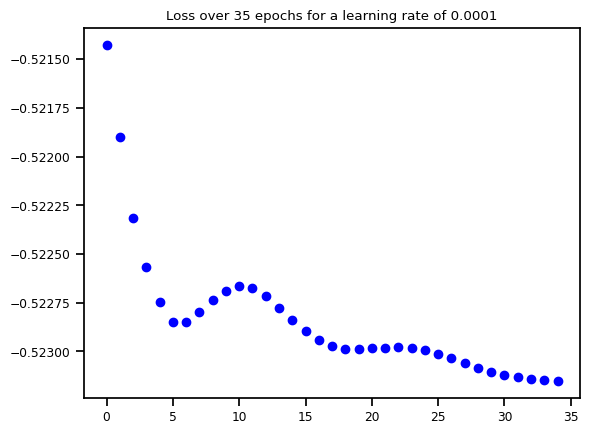

In [ ]:
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epoch} epochs for a learning rate of {learning_rate}")
plt.show()

#### Evaluation of the new parameters:

In [137]:
newModel = Model(param, sim, J1)
trained_model = load_weights(newModel, "Optimized.pth")
#ic(trained_model.state_dict(), J1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
P_t, I_t = run_model_across_batch(Input_NLLL, len_sim, trained_model)

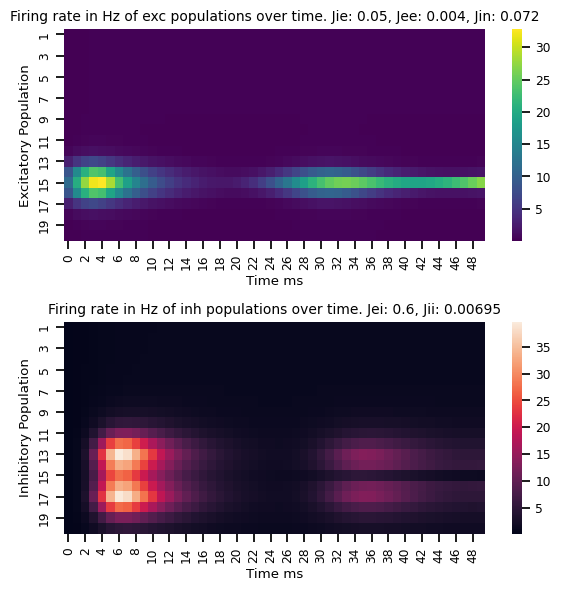

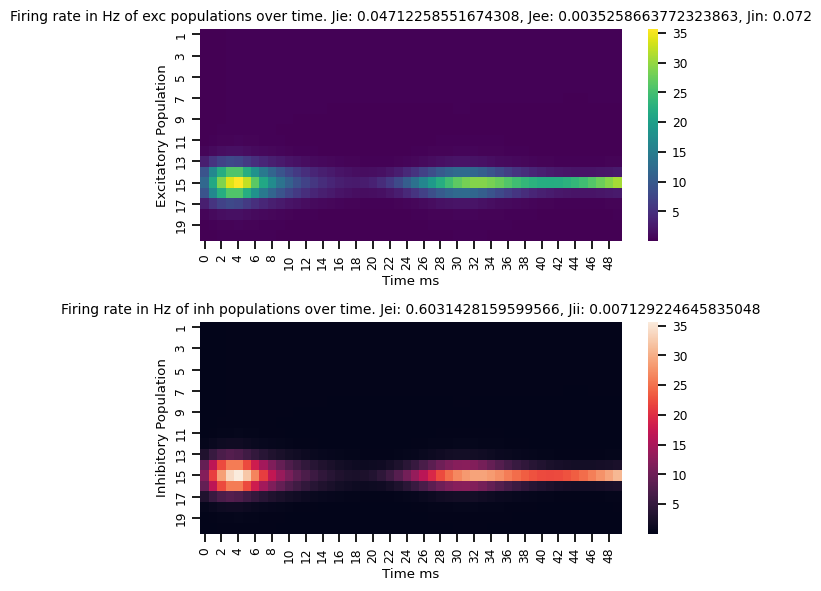

In [138]:
# Prediction before training
HeatMap(P0[0:50,:].detach().numpy(), I0[0:50,:].detach().numpy(), J1)
# Prediction after training
J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P_t[0:50,:].detach().numpy(), P_t[:50,:].detach().numpy(), J2)

#### Evaluation of the new parameters:

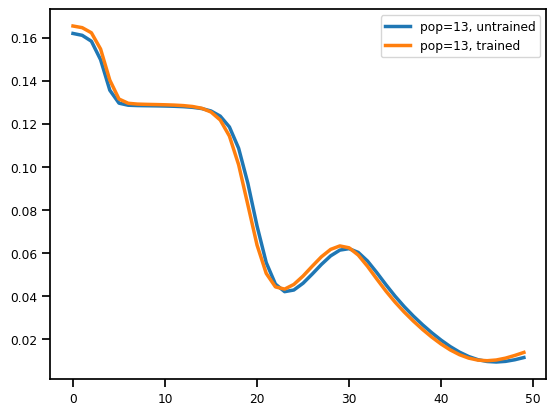

In [104]:
P0_np = np.array(P0.detach().numpy())
PT_np = np.array(P_t.detach().numpy())

P0_norm = preprocessing.normalize(P0_np, axis= 1) 
PT_norm = preprocessing.normalize(PT_np, axis= 1) 

pop = 12
plt.plot(np.arange(0,50), P0_norm[:50,pop], label = f"pop={pop +1}, untrained")
plt.plot(np.arange(0,50), PT_norm[:50,pop], label = f"pop={pop +1}, trained")
plt.legend()

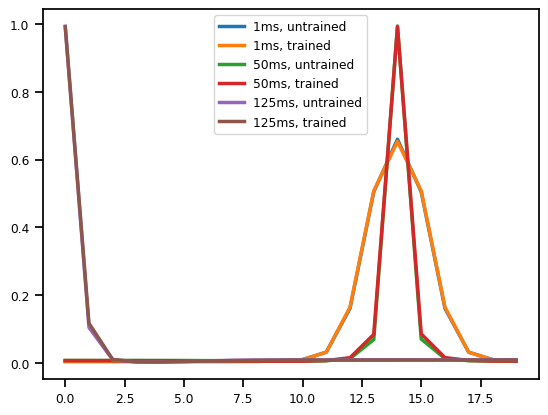

In [82]:

# Normalized plot
t1 = 1
t2 = 50
t3 = 125#1250
   
plot_normalized_plot(P0, P_t, t1)
plot_normalized_plot(P0, P_t, t2)
plot_normalized_plot(P0, P_t, t3)

plt.legend()
plt.show()



Bad parameters

In [88]:
class run_optimization:
    def __init__(self, model, Input, T, modelpath ,opti_name = "Adam" ,num_epoch =100, learning_rate =0.0001):
        criterion = torch.nn.NLLLoss()
        logsoft = nn.LogSoftmax(dim=1)

        self.losses = torch.zeros(num_epoch)

        if opti_name =="Adam":
            self.optimizer = optim.Adam(model.parameters(),
                      lr=learning_rate)
        elif opti_name == "SGD":
            self.optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate, weight_decay = 0.001)
        
        self.run(criterion, logsoft, model, Input, T, modelpath)

    def run(self, criterion, logsoft, model, Input, T, modelpath): 
        model.initiate_state()
        model.train()

        for epoch in range(num_epoch):
            model.initiate_state()
            self.optimizer.zero_grad()  
            P = torch.zeros(Input.shape)   
            I = torch.zeros(Input.shape) 
            dPdt = torch.zeros_like(Input)  

            count = 0
            for i, b in enumerate(T):
                count +=1
                P[i,:], I[i,:], dPdt[i,:], dridt, ampa, gaba = model(Input[int(i),:])
                if count == len_sim: #train_IN.shape[1]: #if we end the simulation time and go to the next batch
                    count = 0
                    model.initiate_state()

            P2 = logsoft(P)
    
            loss = criterion(P2, T.long())  #loss = criterion(P, T.long()) # #criterion(P2, T.long()) # #loss = easyLoss(P2, train_Targets_reshaped) #loss = custom_loss_(P, Target_idx_NLLL, dPdt)
            loss.backward()
            self.optimizer.step()
            
            ic(torch.max(P), torch.min(P),torch.mean(P))
            ic(torch.max(P2), torch.min(P2), torch.mean(P2))
            
            if early_stopper.early_stop(loss):             
                break

            self.losses[epoch] = loss
            print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}')#.item()
            for par in model.parameters():
                print(par.grad)
        
        if '.pth' not in modelpath:
            modelpath += '.pth' #alejandros has pt
        save_weights(model, modelpath)
        


In [89]:
Jbad = {'Jee': 0.04, 'Jei': 0.001, 'Jie': 0.01, 'Jii': 0.4, 'Jin': .00595}
BadModel = Model(param, sim, Jbad)

optim_bad = run_optimization(BadModel, Input_NLLL, Target_idx_NLLL, "Optimized_bad" ,opti_name = "Adam" ,num_epoch =100, learning_rate =0.0001)

ic| torch.max(P): tensor(36.8171, grad_fn=<MaxBackward1>)


Epoch [1/100], Loss: 0.0036494017113000154
tensor(-0., dtype=torch.float64)
tensor(-0.0043, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
tensor(9.1533e-07, dtype=torch.float64)
tensor(-3.1198, dtype=torch.float64)


ic| torch.max(P): tensor(38.3792, grad_fn=<MaxBackward1>)


Epoch [2/100], Loss: 0.003369086654856801
tensor(-0., dtype=torch.float64)
tensor(-0.0037, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)
tensor(9.4956e-07, dtype=torch.float64)
tensor(-2.4959, dtype=torch.float64)


ic| torch.max(P): tensor(39.8887, grad_fn=<MaxBackward1>)


Epoch [3/100], Loss: 0.0031486116349697113
tensor(-0., dtype=torch.float64)
tensor(-0.0029, dtype=torch.float64)
tensor(2.1410e-05, dtype=torch.float64)
tensor(8.3425e-07, dtype=torch.float64)
tensor(-1.9733, dtype=torch.float64)


ic| torch.max(P): tensor(41.3353, grad_fn=<MaxBackward1>)


Epoch [4/100], Loss: 0.0029792494606226683
tensor(-0., dtype=torch.float64)
tensor(-0.0023, dtype=torch.float64)
tensor(-4.9585e-05, dtype=torch.float64)
tensor(6.7640e-07, dtype=torch.float64)
tensor(-1.5313, dtype=torch.float64)


ic| torch.max(P): tensor(42.6928, grad_fn=<MaxBackward1>)


Epoch [5/100], Loss: 0.002853384939953685
tensor(0., dtype=torch.float64)
tensor(-0.0017, dtype=torch.float64)
tensor(-9.1603e-05, dtype=torch.float64)
tensor(5.0331e-07, dtype=torch.float64)
tensor(-1.1536, dtype=torch.float64)


ic| torch.max(P): tensor(43.9470, grad_fn=<MaxBackward1>)


Epoch [6/100], Loss: 0.0027642925269901752
tensor(0., dtype=torch.float64)
tensor(-0.0013, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(3.4940e-07, dtype=torch.float64)
tensor(-0.8274, dtype=torch.float64)


ic| torch.max(P): tensor(45.0933, grad_fn=<MaxBackward1>)


Epoch [7/100], Loss: 0.00270589767023921
tensor(0., dtype=torch.float64)
tensor(-0.0012, dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(2.6192e-07, dtype=torch.float64)
tensor(-0.5424, dtype=torch.float64)


ic| torch.max(P): tensor(46.1015, grad_fn=<MaxBackward1>)


Epoch [8/100], Loss: 0.002672645030543208
tensor(0., dtype=torch.float64)
tensor(-0.0011, dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(2.0395e-07, dtype=torch.float64)
tensor(-0.2922, dtype=torch.float64)


ic| torch.max(P): tensor(46.9862, grad_fn=<MaxBackward1>)


Epoch [9/100], Loss: 0.002659293357282877
tensor(0., dtype=torch.float64)
tensor(-0.0011, dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(1.7038e-07, dtype=torch.float64)
tensor(-0.0722, dtype=torch.float64)


ic| torch.max(P): tensor(47.7275, grad_fn=<MaxBackward1>)


Epoch [10/100], Loss: 0.0026607916224747896
tensor(0., dtype=torch.float64)
tensor(-0.0011, dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(1.4323e-07, dtype=torch.float64)
tensor(0.1202, dtype=torch.float64)


ic| torch.max(P): tensor(48.3113, grad_fn=<MaxBackward1>)


Epoch [11/100], Loss: 0.002672340488061309
tensor(0., dtype=torch.float64)
tensor(-0.0011, dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(1.1768e-07, dtype=torch.float64)
tensor(0.2864, dtype=torch.float64)


ic| torch.max(P): tensor(48.8150, grad_fn=<MaxBackward1>)


Epoch [12/100], Loss: 0.0026894998736679554
tensor(0., dtype=torch.float64)
tensor(-0.0011, dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(9.9341e-08, dtype=torch.float64)
tensor(0.4263, dtype=torch.float64)


ic| torch.max(P): tensor(49.3144, grad_fn=<MaxBackward1>)


Epoch [13/100], Loss: 0.0027083614841103554
tensor(0., dtype=torch.float64)
tensor(-0.0011, dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(6.3210e-08, dtype=torch.float64)
tensor(0.5399, dtype=torch.float64)


ic| torch.max(P): tensor(49.6922, grad_fn=<MaxBackward1>)


Epoch [14/100], Loss: 0.0027257383335381746
tensor(0., dtype=torch.float64)
tensor(-0.0011, dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(1.3289e-08, dtype=torch.float64)
tensor(0.6268, dtype=torch.float64)


ic| torch.max(P): tensor(49.9533, grad_fn=<MaxBackward1>)


Epoch [15/100], Loss: 0.00273932795971632
tensor(0., dtype=torch.float64)
tensor(-0.0010, dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(-6.0898e-08, dtype=torch.float64)
tensor(0.6875, dtype=torch.float64)


ic| torch.max(P): tensor(50.1043, grad_fn=<MaxBackward1>)


Epoch [16/100], Loss: 0.0027477566618472338
tensor(0., dtype=torch.float64)
tensor(-0.0009, dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(-1.9007e-07, dtype=torch.float64)
tensor(0.7228, dtype=torch.float64)


ic| torch.max(P): tensor(50.1525, grad_fn=<MaxBackward1>)


Epoch [17/100], Loss: 0.0027505604084581137
tensor(0., dtype=torch.float64)
tensor(-0.0005, dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(-4.6851e-07, dtype=torch.float64)
tensor(0.7343, dtype=torch.float64)


ic| torch.max(P): tensor(50.1050, grad_fn=<MaxBackward1>)


Epoch [18/100], Loss: 0.002747997408732772
tensor(0., dtype=torch.float64)
tensor(6.4777e-05, dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(-8.4534e-07, dtype=torch.float64)
tensor(0.7241, dtype=torch.float64)


ic| torch.max(P): tensor(49.9675, grad_fn=<MaxBackward1>)


Epoch [19/100], Loss: 0.00274089677259326
tensor(0., dtype=torch.float64)
tensor(0.0007, dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(-1.3322e-06, dtype=torch.float64)
tensor(0.6948, dtype=torch.float64)


ic| torch.max(P): tensor(49.7443, grad_fn=<MaxBackward1>)


Epoch [20/100], Loss: 0.002730438020080328
tensor(0., dtype=torch.float64)
tensor(0.0015, dtype=torch.float64)
tensor(-6.3314e-05, dtype=torch.float64)
tensor(-1.9523e-06, dtype=torch.float64)
tensor(0.6492, dtype=torch.float64)


ic| torch.max(P): tensor(49.4392, grad_fn=<MaxBackward1>)


Epoch [21/100], Loss: 0.0027179045137017965
tensor(0., dtype=torch.float64)
tensor(0.0022, dtype=torch.float64)
tensor(8.8472e-06, dtype=torch.float64)
tensor(-2.4066e-06, dtype=torch.float64)
tensor(0.5902, dtype=torch.float64)


ic| torch.max(P): tensor(49.0596, grad_fn=<MaxBackward1>)


Epoch [22/100], Loss: 0.002704581478610635
tensor(0., dtype=torch.float64)
tensor(0.0025, dtype=torch.float64)
tensor(5.3310e-05, dtype=torch.float64)
tensor(-2.6172e-06, dtype=torch.float64)
tensor(0.5205, dtype=torch.float64)


ic| torch.max(P): tensor(48.6190, grad_fn=<MaxBackward1>)


Epoch [23/100], Loss: 0.0026916710194200277
tensor(0., dtype=torch.float64)
tensor(0.0025, dtype=torch.float64)
tensor(5.6117e-05, dtype=torch.float64)
tensor(-2.4914e-06, dtype=torch.float64)
tensor(0.4428, dtype=torch.float64)


ic| torch.max(P): tensor(48.1362, grad_fn=<MaxBackward1>)


Epoch [24/100], Loss: 0.002680140780285001
tensor(0., dtype=torch.float64)
tensor(0.0021, dtype=torch.float64)
tensor(2.9536e-05, dtype=torch.float64)
tensor(-2.1214e-06, dtype=torch.float64)
tensor(0.3598, dtype=torch.float64)


ic| torch.max(P): tensor(47.6312, grad_fn=<MaxBackward1>)


Epoch [25/100], Loss: 0.00267072394490242
tensor(0., dtype=torch.float64)
tensor(0.0016, dtype=torch.float64)
tensor(-8.4456e-06, dtype=torch.float64)
tensor(-1.6758e-06, dtype=torch.float64)
tensor(0.2740, dtype=torch.float64)


ic| torch.max(P): tensor(47.1233, grad_fn=<MaxBackward1>)


Epoch [26/100], Loss: 0.0026638410054147243
tensor(0., dtype=torch.float64)
tensor(0.0011, dtype=torch.float64)
tensor(-4.1842e-05, dtype=torch.float64)
tensor(-1.2808e-06, dtype=torch.float64)
tensor(0.1880, dtype=torch.float64)


ic| torch.max(P): tensor(46.6292, grad_fn=<MaxBackward1>)


Epoch [27/100], Loss: 0.0026595843955874443
tensor(0., dtype=torch.float64)
tensor(0.0007, dtype=torch.float64)
tensor(-6.9605e-05, dtype=torch.float64)
tensor(-9.5042e-07, dtype=torch.float64)
tensor(0.1039, dtype=torch.float64)


ic| torch.max(P): tensor(46.1629, grad_fn=<MaxBackward1>)


Epoch [28/100], Loss: 0.002657812088727951
tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(-8.6664e-05, dtype=torch.float64)
tensor(-7.1683e-07, dtype=torch.float64)
tensor(0.0237, dtype=torch.float64)


ic| torch.max(P): tensor(45.7360, grad_fn=<MaxBackward1>)


Epoch [29/100], Loss: 0.002658135024830699
tensor(0., dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)
tensor(-9.9122e-05, dtype=torch.float64)
tensor(-5.3936e-07, dtype=torch.float64)
tensor(-0.0505, dtype=torch.float64)


ic| torch.max(P): tensor(45.3574, grad_fn=<MaxBackward1>)


Epoch [30/100], Loss: 0.0026600027922540903
tensor(0., dtype=torch.float64)
tensor(1.7957e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.8593e-07, dtype=torch.float64)
tensor(-0.1171, dtype=torch.float64)


ic| torch.max(P): tensor(45.0337, grad_fn=<MaxBackward1>)


Epoch [31/100], Loss: 0.0026628009509295225
tensor(0., dtype=torch.float64)
tensor(-7.7538e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.1883e-07, dtype=torch.float64)
tensor(-0.1746, dtype=torch.float64)


ic| torch.max(P): tensor(44.7696, grad_fn=<MaxBackward1>)


Epoch [32/100], Loss: 0.0026658838614821434
tensor(0., dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-2.6197e-07, dtype=torch.float64)
tensor(-0.2217, dtype=torch.float64)


ic| torch.max(P): tensor(44.5677, grad_fn=<MaxBackward1>)


Epoch [33/100], Loss: 0.0026687062345445156
tensor(0., dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-2.1350e-07, dtype=torch.float64)
tensor(-0.2575, dtype=torch.float64)


ic| torch.max(P): tensor(44.4282, grad_fn=<MaxBackward1>)


Epoch [34/100], Loss: 0.00267084501683712
tensor(0., dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.8214e-07, dtype=torch.float64)
tensor(-0.2817, dtype=torch.float64)


ic| torch.max(P): tensor(44.3498, grad_fn=<MaxBackward1>)


Epoch [35/100], Loss: 0.0026720224414020777
tensor(0., dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.6249e-07, dtype=torch.float64)
tensor(-0.2942, dtype=torch.float64)


ic| torch.max(P): tensor(44.3291, grad_fn=<MaxBackward1>)


Epoch [36/100], Loss: 0.002672146772965789
tensor(0., dtype=torch.float64)
tensor(-0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.3956e-07, dtype=torch.float64)
tensor(-0.2956, dtype=torch.float64)


ic| torch.max(P): tensor(44.3614, grad_fn=<MaxBackward1>)


Epoch [37/100], Loss: 0.0026712871622294188
tensor(0., dtype=torch.float64)
tensor(-0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.3099e-07, dtype=torch.float64)
tensor(-0.2866, dtype=torch.float64)


ic| torch.max(P): tensor(44.4403, grad_fn=<MaxBackward1>)


Epoch [38/100], Loss: 0.0026696287095546722
tensor(0., dtype=torch.float64)
tensor(-0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.2360e-07, dtype=torch.float64)
tensor(-0.2684, dtype=torch.float64)


ic| torch.max(P): tensor(44.5585, grad_fn=<MaxBackward1>)


Epoch [39/100], Loss: 0.002667456865310669
tensor(0., dtype=torch.float64)
tensor(-0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.2812e-07, dtype=torch.float64)
tensor(-0.2426, dtype=torch.float64)


ic| torch.max(P): tensor(44.7083, grad_fn=<MaxBackward1>)


Epoch [40/100], Loss: 0.0026650631334632635
tensor(0., dtype=torch.float64)
tensor(-0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.4152e-07, dtype=torch.float64)
tensor(-0.2107, dtype=torch.float64)


ic| torch.max(P): tensor(44.8814, grad_fn=<MaxBackward1>)


Epoch [41/100], Loss: 0.0026627241168171167
tensor(0., dtype=torch.float64)
tensor(-0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.4785e-07, dtype=torch.float64)
tensor(-0.1743, dtype=torch.float64)


ic| torch.max(P): tensor(45.0693, grad_fn=<MaxBackward1>)


Epoch [42/100], Loss: 0.0026606942992657423
tensor(0., dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-1.7501e-07, dtype=torch.float64)
tensor(-0.1352, dtype=torch.float64)


ic| torch.max(P): tensor(45.2639, grad_fn=<MaxBackward1>)


Epoch [43/100], Loss: 0.0026591294445097446
tensor(0., dtype=torch.float64)
tensor(-0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-2.0618e-07, dtype=torch.float64)
tensor(-0.0950, dtype=torch.float64)


ic| torch.max(P): tensor(45.4572, grad_fn=<MaxBackward1>)


Epoch [44/100], Loss: 0.0026581166312098503
tensor(0., dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-2.5885e-07, dtype=torch.float64)
tensor(-0.0552, dtype=torch.float64)


ic| torch.max(P): tensor(45.6422, grad_fn=<MaxBackward1>)


Epoch [45/100], Loss: 0.002657635137438774
tensor(0., dtype=torch.float64)
tensor(-0.0002, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-2.9364e-07, dtype=torch.float64)
tensor(-0.0172, dtype=torch.float64)


ic| torch.max(P): tensor(45.8125, grad_fn=<MaxBackward1>)


Epoch [46/100], Loss: 0.0026576253585517406
tensor(0., dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.3974e-07, dtype=torch.float64)
tensor(0.0179, dtype=torch.float64)


ic| torch.max(P): tensor(45.9625, grad_fn=<MaxBackward1>)


Epoch [47/100], Loss: 0.002657974837347865
tensor(0., dtype=torch.float64)
tensor(-3.2680e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9907e-07, dtype=torch.float64)
tensor(0.0491, dtype=torch.float64)


ic| torch.max(P): tensor(46.0877, grad_fn=<MaxBackward1>)


Epoch [48/100], Loss: 0.0026585375890135765
tensor(0., dtype=torch.float64)
tensor(5.0175e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-4.4405e-07, dtype=torch.float64)
tensor(0.0755, dtype=torch.float64)


ic| torch.max(P): tensor(46.1849, grad_fn=<MaxBackward1>)


Epoch [49/100], Loss: 0.002659142017364502
tensor(0., dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-4.9256e-07, dtype=torch.float64)
tensor(0.0967, dtype=torch.float64)


ic| torch.max(P): tensor(46.2517, grad_fn=<MaxBackward1>)


Epoch [50/100], Loss: 0.0026596931274980307
tensor(0., dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-5.6410e-07, dtype=torch.float64)
tensor(0.1122, dtype=torch.float64)


ic| torch.max(P): tensor(46.2873, grad_fn=<MaxBackward1>)


Epoch [51/100], Loss: 0.0026600894052535295
tensor(0., dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-6.0497e-07, dtype=torch.float64)
tensor(0.1221, dtype=torch.float64)


ic| torch.max(P): tensor(46.2918, grad_fn=<MaxBackward1>)


Epoch [52/100], Loss: 0.0026602596044540405
tensor(0., dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-6.2061e-07, dtype=torch.float64)
tensor(0.1264, dtype=torch.float64)


ic| torch.max(P): tensor(46.2666, grad_fn=<MaxBackward1>)


Epoch [53/100], Loss: 0.002660206286236644
tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-6.5421e-07, dtype=torch.float64)
tensor(0.1254, dtype=torch.float64)


ic| torch.max(P): tensor(46.2143, grad_fn=<MaxBackward1>)


Epoch [54/100], Loss: 0.002659957390278578
tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-6.5017e-07, dtype=torch.float64)
tensor(0.1196, dtype=torch.float64)


ic| torch.max(P): tensor(46.1383, grad_fn=<MaxBackward1>)


Epoch [55/100], Loss: 0.0026595594827085733
tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-6.4737e-07, dtype=torch.float64)
tensor(0.1096, dtype=torch.float64)


ic| torch.max(P): tensor(46.0428, grad_fn=<MaxBackward1>)


Epoch [56/100], Loss: 0.002659072168171406
tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-6.1446e-07, dtype=torch.float64)
tensor(0.0962, dtype=torch.float64)


ic| torch.max(P): tensor(45.9326, grad_fn=<MaxBackward1>)


Epoch [57/100], Loss: 0.002658574841916561
tensor(0., dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-5.7330e-07, dtype=torch.float64)
tensor(0.0800, dtype=torch.float64)


ic| torch.max(P): tensor(45.8126, grad_fn=<MaxBackward1>)


Epoch [58/100], Loss: 0.002658132230862975
tensor(0., dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-5.4000e-07, dtype=torch.float64)
tensor(0.0622, dtype=torch.float64)


ic| torch.max(P): tensor(45.6878, grad_fn=<MaxBackward1>)


Epoch [59/100], Loss: 0.002657779725268483
tensor(0., dtype=torch.float64)
tensor(0.0002, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-5.0304e-07, dtype=torch.float64)
tensor(0.0434, dtype=torch.float64)


ic| torch.max(P): tensor(45.5629, grad_fn=<MaxBackward1>)


Epoch [60/100], Loss: 0.002657562494277954
tensor(0., dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-4.6369e-07, dtype=torch.float64)
tensor(0.0244, dtype=torch.float64)


ic| torch.max(P): tensor(45.4422, grad_fn=<MaxBackward1>)


Epoch [61/100], Loss: 0.0026574444491416216
tensor(0., dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-4.3884e-07, dtype=torch.float64)
tensor(0.0063, dtype=torch.float64)


ic| torch.max(P): tensor(45.3297, grad_fn=<MaxBackward1>)


Epoch [62/100], Loss: 0.002657453529536724
tensor(0., dtype=torch.float64)
tensor(6.1209e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-4.0343e-07, dtype=torch.float64)
tensor(-0.0106, dtype=torch.float64)


ic| torch.max(P): tensor(45.2283, grad_fn=<MaxBackward1>)


Epoch [63/100], Loss: 0.002657524077221751
tensor(0., dtype=torch.float64)
tensor(1.3735e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.7545e-07, dtype=torch.float64)
tensor(-0.0254, dtype=torch.float64)


ic| torch.max(P): tensor(45.1405, grad_fn=<MaxBackward1>)


Epoch [64/100], Loss: 0.002657661447301507
tensor(0., dtype=torch.float64)
tensor(-3.9182e-06, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.5597e-07, dtype=torch.float64)
tensor(-0.0378, dtype=torch.float64)


ic| torch.max(P): tensor(45.0680, grad_fn=<MaxBackward1>)


Epoch [65/100], Loss: 0.0026577890384942293
tensor(0., dtype=torch.float64)
tensor(-3.9446e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.3419e-07, dtype=torch.float64)
tensor(-0.0474, dtype=torch.float64)


ic| torch.max(P): tensor(45.0116, grad_fn=<MaxBackward1>)


Epoch [66/100], Loss: 0.0026578931137919426
tensor(0., dtype=torch.float64)
tensor(-6.4178e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.2241e-07, dtype=torch.float64)
tensor(-0.0540, dtype=torch.float64)


ic| torch.max(P): tensor(44.9713, grad_fn=<MaxBackward1>)


Epoch [67/100], Loss: 0.0026579538825899363
tensor(0., dtype=torch.float64)
tensor(-7.3862e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.1249e-07, dtype=torch.float64)
tensor(-0.0577, dtype=torch.float64)


ic| torch.max(P): tensor(44.9468, grad_fn=<MaxBackward1>)


Epoch [68/100], Loss: 0.002657961333170533
tensor(0., dtype=torch.float64)
tensor(-9.8618e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.0290e-07, dtype=torch.float64)
tensor(-0.0584, dtype=torch.float64)


ic| torch.max(P): tensor(44.9365, grad_fn=<MaxBackward1>)


Epoch [69/100], Loss: 0.002657908946275711
tensor(0., dtype=torch.float64)
tensor(-8.4494e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.0990e-07, dtype=torch.float64)
tensor(-0.0565, dtype=torch.float64)


ic| torch.max(P): tensor(44.9390, grad_fn=<MaxBackward1>)


Epoch [70/100], Loss: 0.0026578158140182495
tensor(0., dtype=torch.float64)
tensor(-6.8181e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.1531e-07, dtype=torch.float64)
tensor(-0.0521, dtype=torch.float64)


ic| torch.max(P): tensor(44.9520, grad_fn=<MaxBackward1>)


Epoch [71/100], Loss: 0.0026577189564704895
tensor(0., dtype=torch.float64)
tensor(-5.1034e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.2307e-07, dtype=torch.float64)
tensor(-0.0459, dtype=torch.float64)


ic| torch.max(P): tensor(44.9732, grad_fn=<MaxBackward1>)


Epoch [72/100], Loss: 0.0026575925294309855
tensor(0., dtype=torch.float64)
tensor(-3.3736e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.3457e-07, dtype=torch.float64)
tensor(-0.0381, dtype=torch.float64)


ic| torch.max(P): tensor(44.9999, grad_fn=<MaxBackward1>)


Epoch [73/100], Loss: 0.002657487988471985
tensor(0., dtype=torch.float64)
tensor(1.5455e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.6270e-07, dtype=torch.float64)
tensor(-0.0293, dtype=torch.float64)


ic| torch.max(P): tensor(45.0296, grad_fn=<MaxBackward1>)


Epoch [74/100], Loss: 0.0026573960203677416
tensor(0., dtype=torch.float64)
tensor(5.1307e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.7815e-07, dtype=torch.float64)
tensor(-0.0200, dtype=torch.float64)


ic| torch.max(P): tensor(45.0597, grad_fn=<MaxBackward1>)


Epoch [75/100], Loss: 0.002657334553077817
tensor(0., dtype=torch.float64)
tensor(5.5728e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.8467e-07, dtype=torch.float64)
tensor(-0.0105, dtype=torch.float64)


ic| torch.max(P): tensor(45.0877, grad_fn=<MaxBackward1>)


Epoch [76/100], Loss: 0.0026573154609650373
tensor(0., dtype=torch.float64)
tensor(5.9033e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.8584e-07, dtype=torch.float64)
tensor(-0.0016, dtype=torch.float64)


ic| torch.max(P): tensor(45.1115, grad_fn=<MaxBackward1>)


Epoch [77/100], Loss: 0.0026573098730295897
tensor(0., dtype=torch.float64)
tensor(6.5850e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9057e-07, dtype=torch.float64)
tensor(0.0066, dtype=torch.float64)


ic| torch.max(P): tensor(45.1294, grad_fn=<MaxBackward1>)


Epoch [78/100], Loss: 0.002657317090779543
tensor(0., dtype=torch.float64)
tensor(5.5857e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.8549e-07, dtype=torch.float64)
tensor(0.0138, dtype=torch.float64)


ic| torch.max(P): tensor(45.1399, grad_fn=<MaxBackward1>)


Epoch [79/100], Loss: 0.0026573489885777235
tensor(0., dtype=torch.float64)
tensor(5.9664e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9031e-07, dtype=torch.float64)
tensor(0.0195, dtype=torch.float64)


ic| torch.max(P): tensor(45.1423, grad_fn=<MaxBackward1>)


Epoch [80/100], Loss: 0.0026573683135211468
tensor(0., dtype=torch.float64)
tensor(7.7135e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9731e-07, dtype=torch.float64)
tensor(0.0238, dtype=torch.float64)


ic| torch.max(P): tensor(45.1361, grad_fn=<MaxBackward1>)


Epoch [81/100], Loss: 0.0026573860086500645
tensor(0., dtype=torch.float64)
tensor(8.2059e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9615e-07, dtype=torch.float64)
tensor(0.0265, dtype=torch.float64)


ic| torch.max(P): tensor(45.1213, grad_fn=<MaxBackward1>)


Epoch [82/100], Loss: 0.002657385542988777
tensor(0., dtype=torch.float64)
tensor(7.4851e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9157e-07, dtype=torch.float64)
tensor(0.0277, dtype=torch.float64)


ic| torch.max(P): tensor(45.0985, grad_fn=<MaxBackward1>)


Epoch [83/100], Loss: 0.0026573718059808016
tensor(0., dtype=torch.float64)
tensor(8.2743e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9072e-07, dtype=torch.float64)
tensor(0.0274, dtype=torch.float64)


ic| torch.max(P): tensor(45.0683, grad_fn=<MaxBackward1>)


Epoch [84/100], Loss: 0.0026573447976261377
tensor(0., dtype=torch.float64)
tensor(9.3143e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9153e-07, dtype=torch.float64)
tensor(0.0258, dtype=torch.float64)


ic| torch.max(P): tensor(45.0445, grad_fn=<MaxBackward1>)


Epoch [85/100], Loss: 0.0026573229115456343
tensor(0., dtype=torch.float64)
tensor(8.9804e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.8873e-07, dtype=torch.float64)
tensor(0.0231, dtype=torch.float64)


ic| torch.max(P): tensor(45.0194, grad_fn=<MaxBackward1>)


Epoch [86/100], Loss: 0.0026572856586426497
tensor(0., dtype=torch.float64)
tensor(9.7140e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9283e-07, dtype=torch.float64)
tensor(0.0194, dtype=torch.float64)


ic| torch.max(P): tensor(44.9925, grad_fn=<MaxBackward1>)


Epoch [87/100], Loss: 0.00265725189819932
tensor(0., dtype=torch.float64)
tensor(9.1037e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.9253e-07, dtype=torch.float64)
tensor(0.0151, dtype=torch.float64)


ic| torch.max(P): tensor(44.9649, grad_fn=<MaxBackward1>)


Epoch [88/100], Loss: 0.002657224889844656
tensor(0., dtype=torch.float64)
tensor(8.6689e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.8814e-07, dtype=torch.float64)
tensor(0.0104, dtype=torch.float64)


ic| torch.max(P): tensor(44.9375, grad_fn=<MaxBackward1>)


Epoch [89/100], Loss: 0.0026571915950626135
tensor(0., dtype=torch.float64)
tensor(5.6667e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.7719e-07, dtype=torch.float64)
tensor(0.0057, dtype=torch.float64)


ic| torch.max(P): tensor(44.9108, grad_fn=<MaxBackward1>)


Epoch [90/100], Loss: 0.0026571874041110277
tensor(0., dtype=torch.float64)
tensor(4.9435e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.6861e-07, dtype=torch.float64)
tensor(0.0011, dtype=torch.float64)


ic| torch.max(P): tensor(44.8854, grad_fn=<MaxBackward1>)


Epoch [91/100], Loss: 0.0026571806520223618
tensor(0., dtype=torch.float64)
tensor(4.0970e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.6516e-07, dtype=torch.float64)
tensor(-0.0031, dtype=torch.float64)


ic| torch.max(P): tensor(44.8622, grad_fn=<MaxBackward1>)


Epoch [92/100], Loss: 0.0026571741327643394
tensor(0., dtype=torch.float64)
tensor(3.7276e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.6075e-07, dtype=torch.float64)
tensor(-0.0068, dtype=torch.float64)


ic| torch.max(P): tensor(44.8417, grad_fn=<MaxBackward1>)


Epoch [93/100], Loss: 0.0026571606285870075
tensor(0., dtype=torch.float64)
tensor(1.8455e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.5071e-07, dtype=torch.float64)
tensor(-0.0097, dtype=torch.float64)


ic| torch.max(P): tensor(44.8239, grad_fn=<MaxBackward1>)


Epoch [94/100], Loss: 0.0026571659836918116
tensor(0., dtype=torch.float64)
tensor(2.3699e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.4913e-07, dtype=torch.float64)
tensor(-0.0119, dtype=torch.float64)


ic| torch.max(P): tensor(44.8093, grad_fn=<MaxBackward1>)


Epoch [95/100], Loss: 0.0026571634225547314
tensor(0., dtype=torch.float64)
tensor(2.5298e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.4798e-07, dtype=torch.float64)
tensor(-0.0133, dtype=torch.float64)


ic| torch.max(P): tensor(44.7978, grad_fn=<MaxBackward1>)


Epoch [96/100], Loss: 0.002657161559909582
tensor(0., dtype=torch.float64)
tensor(2.5674e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.4496e-07, dtype=torch.float64)
tensor(-0.0138, dtype=torch.float64)


ic| torch.max(P): tensor(44.7895, grad_fn=<MaxBackward1>)


Epoch [97/100], Loss: 0.0026571524795144796
tensor(0., dtype=torch.float64)
tensor(2.6998e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.4676e-07, dtype=torch.float64)
tensor(-0.0135, dtype=torch.float64)


ic| torch.max(P): tensor(44.7841, grad_fn=<MaxBackward1>)


Epoch [98/100], Loss: 0.002657137345522642
tensor(0., dtype=torch.float64)
tensor(3.3608e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.4842e-07, dtype=torch.float64)
tensor(-0.0125, dtype=torch.float64)


ic| torch.max(P): tensor(44.7811, grad_fn=<MaxBackward1>)


Epoch [99/100], Loss: 0.0026571250054985285
tensor(0., dtype=torch.float64)
tensor(2.7783e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.4530e-07, dtype=torch.float64)
tensor(-0.0110, dtype=torch.float64)


ic| torch.max(P): tensor(44.7798, grad_fn=<MaxBackward1>)


Epoch [100/100], Loss: 0.002657103817909956
tensor(0., dtype=torch.float64)
tensor(2.6431e-05, dtype=torch.float64)
tensor(-0.0001, dtype=torch.float64)
tensor(-3.4514e-07, dtype=torch.float64)
tensor(-0.0090, dtype=torch.float64)


C:\Users\knzga\AppData\Local\Temp\ipykernel_12664\2603301172.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')


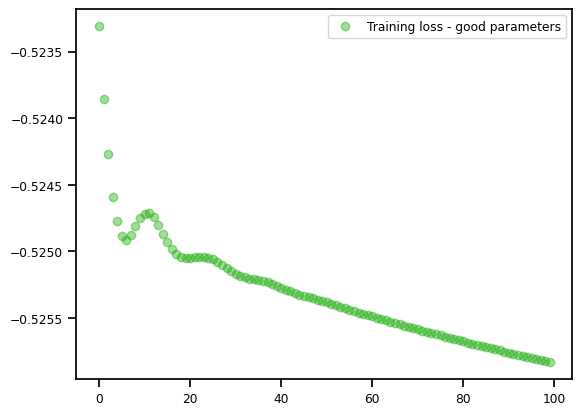

In [96]:
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')
plt.legend()

C:\Users\knzga\AppData\Local\Temp\ipykernel_12664\3463038787.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')


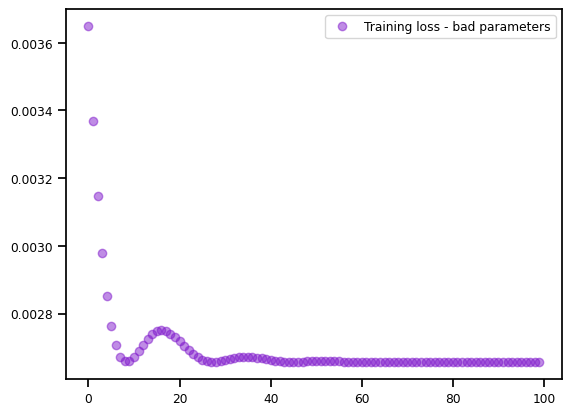

In [94]:
plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')
plt.legend()

C:\Users\knzga\AppData\Local\Temp\ipykernel_12664\345714583.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')
C:\Users\knzga\AppData\Local\Temp\ipykernel_12664\345714583.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')


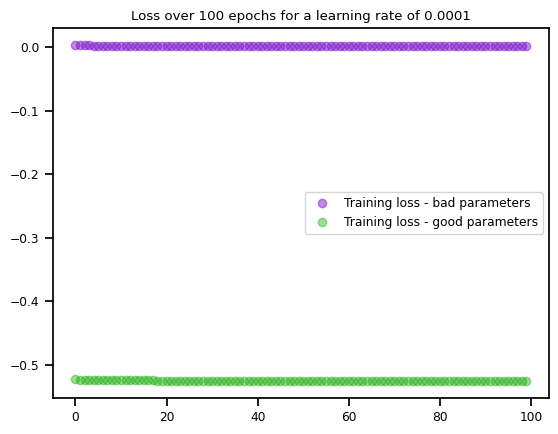

In [92]:

plt.plot(np.arange(optim_bad.losses.shape[0]), optim_bad.losses.detach().numpy(), 'bo', color = [.5,.1,.8, .5],label='Training loss - bad parameters')
plt.plot(np.arange(losses.shape[0]), losses.detach().numpy(), 'bo',color = "#11aa0066", label='Training loss - good parameters')
plt.title(f"Loss over {num_epoch} epochs for a learning rate of {learning_rate}")
plt.legend()
plt.show()

In [98]:

BadModel_trained = load_weights(BadModel, "Optimized_bad.pth")
#ic(trained_model.state_dict(), J1)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
P_Bad, I_Bad = run_model_across_batch(Input_NLLL, len_sim, BadModel)
P_Bad_t, I_Bad_t = run_model_across_batch(Input_NLLL, len_sim, BadModel_trained)

ic| torch.max(P_Bad_t): tensor(44.7796, grad_fn=<MaxBackward1>)


ic| torch.max(P_Bad): tensor(44.7796, grad_fn=<MaxBackward1>)


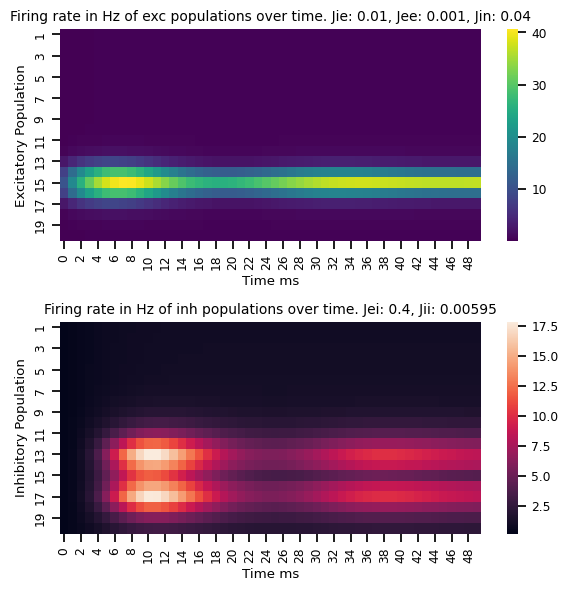

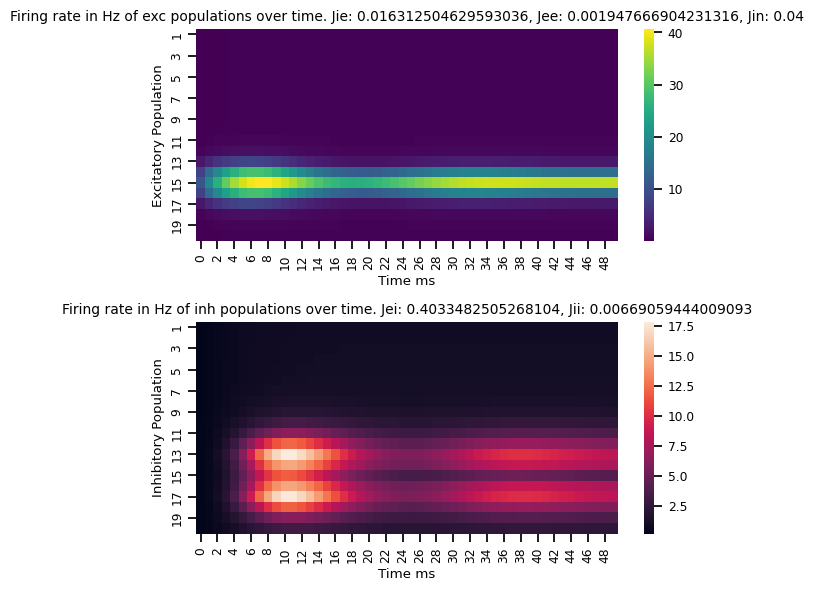

In [101]:
ic(torch.max(P_Bad_t))
ic(torch.max(P_Bad))

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(P_Bad[:50,:].detach().numpy(), I_Bad[:50,:].detach().numpy(), Jbad)
J2= {'Jee': BadModel_trained.Jee.detach().numpy(), 'Jei': BadModel_trained.Jei.detach().numpy(), 'Jie': BadModel_trained.Jie.detach().numpy(), 'Jii': BadModel_trained.Jii.detach().numpy(), 'Jin': BadModel_trained.Jin.detach().numpy()}
HeatMap(P_Bad_t[:50,:].detach().numpy(), I_Bad_t[:50,:].detach().numpy(), J2)

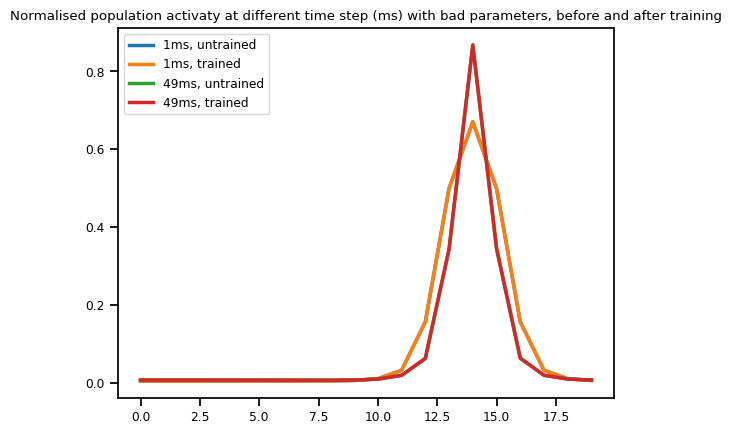

In [115]:
t2 = 10
t3 = 49
plot_normalized_plot(P_Bad, P_Bad_t, t1)
#plot_normalized_plot(P_Bad, P_Bad_t, t2)
plot_normalized_plot(P_Bad, P_Bad_t, t3)
plt.title(f"Normalised population activaty at different time step (ms) with bad parameters, before and after training")

plt.legend()

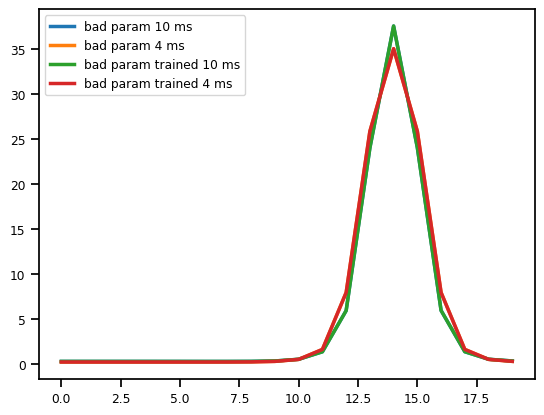

In [105]:
t = 10
t2= 4
#plt.plot(np.arange((r_e[t,:].detach().numpy()).shape[0]), r_e[t,:].detach().numpy(), label = f"time {t} ms")
#plt.plot(np.arange((r_e[t2,:].detach().numpy()).shape[0]), r_e[t2,:].detach().numpy(), label = f"time {t2} ms")
plt.plot(np.arange((P_Bad[t,:].detach().numpy()).shape[0]), P_Bad[t,:].detach().numpy(), label = f"bad param {t} ms")
plt.plot(np.arange((P_Bad[t2,:].detach().numpy()).shape[0]), P_Bad[t2,:].detach().numpy(), label = f"bad param {t2} ms")
plt.plot(np.arange((P_Bad_t[t,:].detach().numpy()).shape[0]), P_Bad_t[t,:].detach().numpy(), label = f"bad param trained {t} ms")
plt.plot(np.arange((P_Bad_t[t2,:].detach().numpy()).shape[0]), P_Bad_t[t2,:].detach().numpy(), label = f"bad param trained {t2} ms")
plt.legend()

